# same as example in example.ipynb notebook, except we're predicting next few points instead

In [1]:
import math
import torch
import torchcde

import matplotlib.pyplot as plt

A CDE model looks like

$ z_t = z_0 + \int_0^t f_\theta(z_s) dX_s $

Where $X$ is your data and $f_\theta$ is a neural network. So the first thing we need to do is define such an $f_\theta$.

That's what this CDEFunc class does.
Here we've built a small single-hidden-layer neural network, whose hidden layer is of width 128.

In [2]:
class CDEFunc(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels):
        ######################
        # input_channels is the number of input channels in the data X. (Determined by the data.)
        # hidden_channels is the number of channels for z_t. (Determined by you!)
        ######################
        super(CDEFunc, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels

        self.linear1 = torch.nn.Linear(hidden_channels, 128)
#         self.linear11 = torch.nn.Linear(128, 128)
        self.linear2 = torch.nn.Linear(128, input_channels * hidden_channels)
        
    ######################
    # For most purposes the t argument can probably be ignored; unless you want your CDE to behave differently at
    # different times, which would be unusual. But it's there if you need it!
    ######################
    def forward(self, t, z):
        # z has shape (batch, hidden_channels)
        z = self.linear1(z)
        z = z.relu()
        
#         z = self.linear11(z)
#         z = z.relu()
        
        z = self.linear2(z)
        ######################
        # Easy-to-forget gotcha: Best results tend to be obtained by adding a final tanh nonlinearity.
        ######################
        z = z.tanh()
        ######################
        # Ignoring the batch dimension, the shape of the output tensor must be a matrix,
        # because we need it to represent a linear map from R^input_channels to R^hidden_channels.
        ######################
        z = z.view(z.size(0), self.hidden_channels, self.input_channels)
        return z

Next, we need to package CDEFunc up into a model that computes the integral.

In [3]:
class NeuralCDE(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels, n_steps):
        super(NeuralCDE, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.n_steps = n_steps
        self.func = CDEFunc(input_channels, hidden_channels)
        self.initial = torch.nn.Linear(input_channels, hidden_channels)
        self.readout = torch.nn.Linear(hidden_channels, n_steps*input_channels)
        
    def forward(self, coeffs):
#         print(f"coeffs shape: {coeffs.shape}")
        
        X = torchcde.NaturalCubicSpline(coeffs)
        
        ######################
        # Easy to forget gotcha: Initial hidden state should be a function of the first observation.
        ######################
        X0 = X.evaluate(X.interval[0])
#         print(f"X0 shape: {X0.shape}")
        
        z0 = self.initial(X0)
#         print(f"z0 shape: {z0.shape}")
        
        ######################
        # Actually solve the CDE.
        ######################
        z_T = torchcde.cdeint(X=X,
                              z0=z0,
                              func=self.func,
                              t=X.interval)
        
        ######################
        # Both the initial value and the terminal value are returned from cdeint; extract just the terminal value,
        # and then apply a linear map.
        ######################
        z_T = z_T[:, 1]
#         print(f"z_T shape: {z_T.shape}")
        
        pred_y = self.readout(z_T)
        pred_y = pred_y.view(pred_y.size(0), self.n_steps, self.input_channels)
#         print(f"pred_y shape: {pred_y.shape}")
#         return pred_y, z_T
        return pred_y

In [4]:
######################
# Now we need some data.
# Here we have a simple example which generates some spirals, some going clockwise, some going anticlockwise.
######################
def get_data(n_steps_ahead = 5):
    t = torch.linspace(0., 4 * math.pi, 100)

    start = torch.rand(128) * 2 * math.pi
    x_pos = torch.cos(start.unsqueeze(1) + t.unsqueeze(0)) / (1 + 0.5 * t)
    x_pos[:64] *= -1
    y_pos = torch.sin(start.unsqueeze(1) + t.unsqueeze(0)) / (1 + 0.5 * t)
    x_pos += 0.01 * torch.randn_like(x_pos)
    y_pos += 0.01 * torch.randn_like(y_pos)
    ######################
    # Easy to forget gotcha: time should be included as a channel; Neural CDEs need to be explicitly told the
    # rate at which time passes. Here, we have a regularly sampled dataset, so appending time is pretty simple.
    ######################
    X = torch.stack([t.unsqueeze(0).repeat(128, 1), x_pos, y_pos], dim=2)
    y = X[:, -n_steps_ahead:, :]
#     y = y.view(y.size(0), y.size(1)*y.size(2))
    X = X[:, :-n_steps_ahead, :]
    
    ######################
    # X is a tensor of observations, of shape (batch=128, sequence=95, channels=3)
    # y is a tensor of labels, of shape (batch=128, sequence=5, channels=3) 
    ######################
    return X, y

# main func

In [5]:
n_steps_ahead = 10
train_X, train_y = get_data(n_steps_ahead)

In [6]:
######################
# input_channels=3 because we have both the horizontal and vertical position of a point in the spiral, and time.
# hidden_channels=8 is the number of hidden channels for the evolving z_t, which we get to choose.
# output_channels=3 because we're predicting next five points
######################
model = NeuralCDE(input_channels=3, hidden_channels=24, n_steps=n_steps_ahead)
optimizer = torch.optim.Adam(model.parameters())

In [7]:
######################
# Now we turn our dataset into a continuous path. We do this here via natural cubic spline interpolation.
# The resulting `train_coeffs` is a tensor describing the path.
# For most problems, it's probably easiest to save this tensor and treat it as the dataset.
######################
train_coeffs = torchcde.natural_cubic_coeffs(train_X)

In [8]:
num_epochs = 250
print_every = 10
train_dataset = torch.utils.data.TensorDataset(train_coeffs, train_y)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32)
for epoch in range(1, num_epochs+1):
    for batch in train_dataloader:
        batch_coeffs, batch_y = batch
        pred_y = model(batch_coeffs).squeeze(-1)
        loss = torch.nn.functional.mse_loss(pred_y[:, 0:], batch_y[:, 0:])
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    if epoch%print_every == 0:
        print('Epoch: {}   Training loss: {}'.format(epoch, loss.item()))

Epoch: 10   Training loss: 0.7393518090248108
Epoch: 20   Training loss: 0.05326348915696144
Epoch: 30   Training loss: 0.019472844898700714
Epoch: 40   Training loss: 0.01287100836634636
Epoch: 50   Training loss: 0.009320485405623913
Epoch: 60   Training loss: 0.00725896330550313
Epoch: 70   Training loss: 0.005923126358538866
Epoch: 80   Training loss: 0.005040875636041164
Epoch: 90   Training loss: 0.004383477848023176
Epoch: 100   Training loss: 0.003847944550216198
Epoch: 110   Training loss: 0.003508341731503606
Epoch: 120   Training loss: 0.0034232221078127623
Epoch: 130   Training loss: 0.0032504918053746223
Epoch: 140   Training loss: 0.002533639781177044
Epoch: 150   Training loss: 0.002288159681484103
Epoch: 160   Training loss: 0.002063797088339925
Epoch: 170   Training loss: 0.0019398212898522615
Epoch: 180   Training loss: 0.0019680934492498636
Epoch: 190   Training loss: 0.008898443542420864
Epoch: 200   Training loss: 0.0017759293550625443
Epoch: 210   Training loss: 0

In [16]:
def split_tensor(tensor):
    tensor = tensor.detach().numpy()
    T, X, Y = tensor[:, 0], tensor[:, 1], tensor[:, 2]
    return T, X, Y
def plot(x, y, pred_y, ix, three_dim = False):
    obs_T, obs_X, obs_Y = split_tensor(x[0])
    hid_T, hid_X, hid_Y = split_tensor(y[0])
    pred_T, pred_X, pred_Y = split_tensor(pred_y[0])
    
    fig = plt.figure(figsize=(8,8))
    if three_dim:
        ax = fig.gca(projection="3d")
        ax.scatter(obs_T, obs_X, obs_Y, color="blue", label="obs")
        ax.scatter(hid_T, hid_X, hid_Y, color="green", label="hidden")
        ax.scatter(pred_T, pred_X, pred_Y, color="red", label="predicted")
    else:
        ax = fig.gca()
        ax.scatter(obs_X, obs_Y, color="blue", label="obs")
        ax.scatter(hid_X, hid_Y, color="green", label="hidden")
        ax.scatter(pred_X, pred_Y, color="red", label="predicted")
    ax.legend()

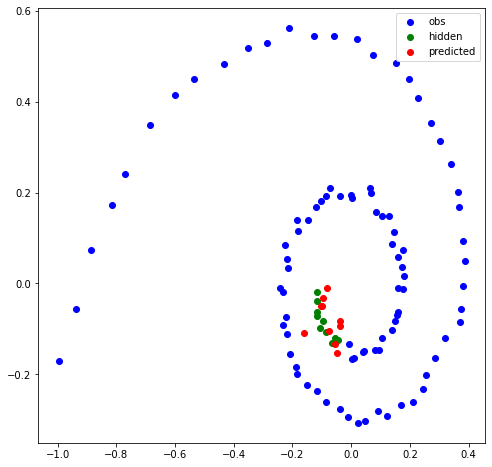

In [22]:
ix = 4
test_X, test_y = get_data(n_steps_ahead)
x = test_X[ix:ix+1, :, :]
y = test_y[ix:ix+11, :, :]
test_coeffs = torchcde.natural_cubic_coeffs(x)
pred_y = model(test_coeffs)

plot(x, y, pred_y, ix, three_dim=False)